## FPoliSolutions, LLC; Asset Monitoring and Predictive Maintenance

## Prediction
## Arnab Dey Sarkar

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

In [138]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import StratifiedKFold

In [139]:
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [140]:
df = pd.read_csv("training_data.csv")

In [141]:
input_names = df.drop(columns=['Y']).columns
lf= df.copy().\
reset_index().\
rename(columns={'index': 'rowid'}).\
melt(id_vars=['rowid', 'Y'], value_vars=input_names, ignore_index=True)

In [142]:
high_skew_inputs = input_names[ np.abs(df.drop(columns=['Y']).skew()) > 1 ]

In [143]:
high_skew_inputs

Index(['Z07', 'Z08', 'Z09', 'V02', 'V11', 'V27', 'V28', 'V29'], dtype='object')

In [144]:
# check if the values are negative because the log and square root transformations cannot be applied to negative values
lf.loc[ (lf.variable.isin(high_skew_inputs)) & (lf.value < 0), :].groupby(['variable']).size()

variable
V02    110
V11    119
V29    215
Z09    136
dtype: int64

In [145]:
lf_skew = lf.loc[ lf.variable.isin(high_skew_inputs), :].copy()

lf_skew = lf_skew.loc[ ~lf_skew.variable.isin(['V02', 'V11', 'V29', 'Z09']), :].copy()

In [146]:
lf_skew['shift_value'] = 1 - lf_skew.value
lf_skew['log_shift_value'] = np.log( lf_skew.shift_value )

In [147]:
# Convert to short format using pivot
data = lf_skew.pivot(index='rowid', columns='variable', values='log_shift_value').reset_index()
data = data.drop(columns=['rowid'])

In [148]:
df_transformed = df.copy()
df_transformed = df_transformed.drop(columns=['Z07','Z08','V27','V28'])


In [149]:
df_transformed['Z07'] = data['Z07']
df_transformed['Z08'] = data['Z08']
df_transformed['V27'] = data['V27']
df_transformed['V28'] = data['V28']

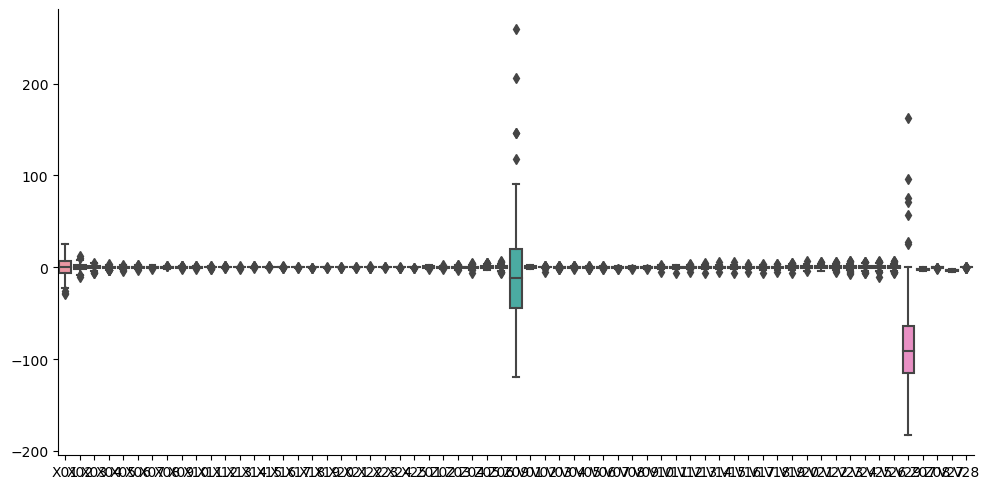

In [150]:
sns.catplot(data = df_transformed.drop(columns=['Y']), kind='box', aspect=2)

plt.show()

We clearly need to scale the data.

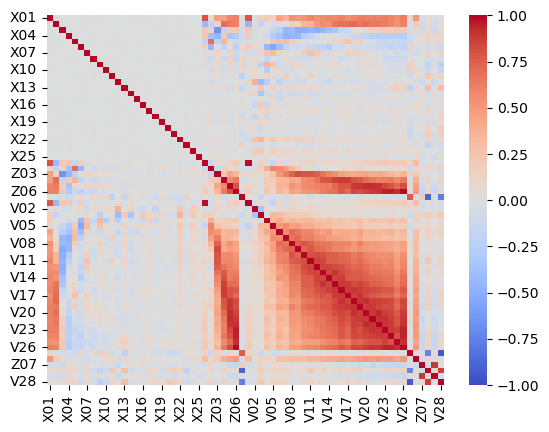

In [151]:
fig, ax = plt.subplots()

sns.heatmap(data = df_transformed.corr(numeric_only=True),
            vmin=-1, vmax=1, center=0,
            cmap='coolwarm', 
            ax=ax)

plt.show()

We observe The INPUTS are HIGHLY correlated. Let us first standardize the original data and later we will look at the transformed data. We will also do PCA for each data

In [152]:
# Standardize original data df

df_features = df.drop(columns=['Y'])

In [153]:
# Let's now standardize the numeric columns
X_features = StandardScaler().fit_transform(df_features )

In [154]:
X_features.shape

(223, 63)

In [155]:
# Convert the standardized features to a DataFrame
df_standardized = pd.DataFrame(X_features, columns=df_features.columns)
df_standardized['Y']=df.Y

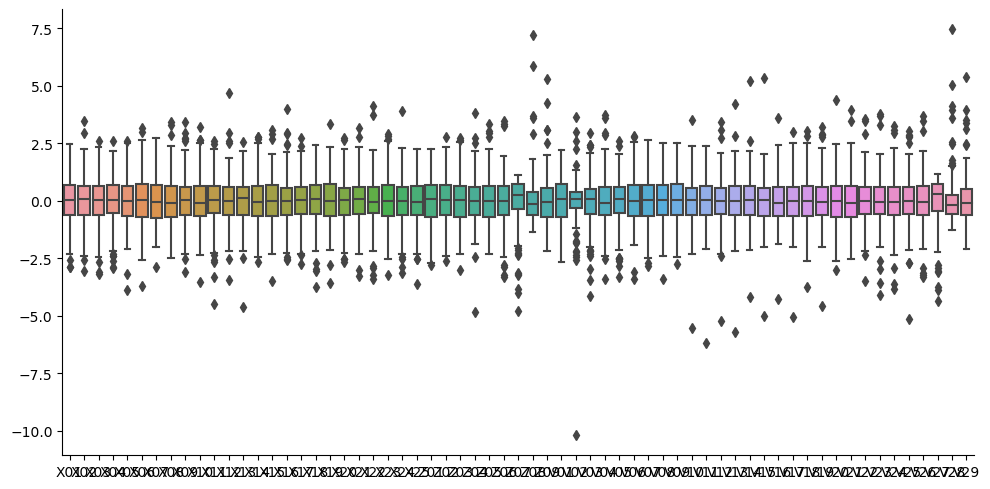

In [156]:
# check standardization worked
sns.catplot(data = pd.DataFrame(X_features, columns=df_features.columns), kind='box', aspect=2)

plt.show()

In [157]:
df_features_transformed = df_transformed.drop(columns=['Y'])

In [158]:
# Let's now standardize the numeric columns
X_features_transformed = StandardScaler().fit_transform(df_features_transformed )
X_features_transformed.shape

(223, 63)

In [159]:
# Convert the standardized features to a DataFrame
df_standardized_transformed = pd.DataFrame(X_features_transformed, columns=df_features_transformed.columns)



In [160]:
df_standardized_transformed['Y'] = df.Y

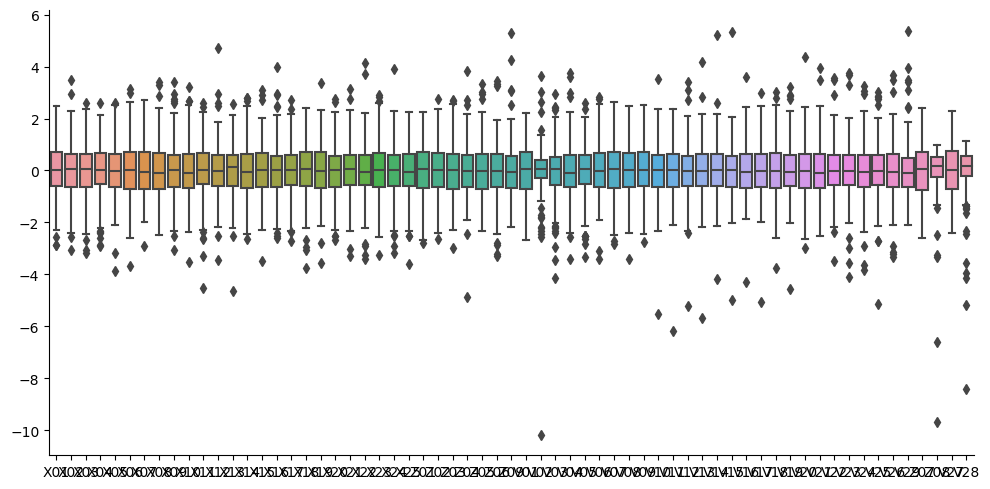

In [161]:
# check standardization worked
sns.catplot(data = pd.DataFrame(X_features_transformed, columns=df_features_transformed.columns), kind='box', aspect=2)

plt.show()

In [162]:
# Apply PCA to the transformed inputs and create linear additive features from the PCs.

X_pca_transformed = PCA().fit_transform(X_features_transformed)


In [163]:
df_pca_transformed = pd.DataFrame( X_pca_transformed, 
        columns=['pc%02d' % d for d in range(1, X_pca_transformed.shape[1]+1)])

In [164]:
X_pca = PCA().fit_transform( X_features )
df_pca = pd.DataFrame( X_pca, 
                             columns=['pc%02d' % d for d in range(1, X_pca.shape[1]+1)])
df_pca['Y'] = df.Y
df_pca_add = df_pca.iloc[:, :13].copy()
df_pca_add['Y'] = df_transformed.Y
df_pca_transformed_add = df_pca_transformed.iloc[:, :13].copy()
df_pca_transformed_add['Y'] = df_standardized_transformed.Y
df_pca_int = df_pca.iloc[:, :11].copy()
df_pca_int['Y'] = df_transformed.Y

### Used model

I will use the mod_03 which was the additive model on standardized feature and the best accurate model mod_07.

**Model 3**

In [165]:
formula_linear = 'Y ~ ' + ' + '.join(df_standardized_transformed.drop(columns= 'Y').columns)
mod_03 = smf.ols(formula=formula_linear, data=df_standardized_transformed).fit() 

In [166]:
mod_03.params

Intercept    0.618834
X01         -0.593080
X02          0.123625
X03         -0.000392
X04          0.124743
               ...   
V29          0.039919
Z07          0.353333
Z08         -0.007782
V27         -0.356414
V28         -0.287535
Length: 64, dtype: float64

**Model 7**

In [167]:
# Apply PCA to the transformed inputs and create all pairwise interactions between the PCs.
df_pca_transformed_int = df_pca_transformed.iloc[:, :11].copy()
df_pca_transformed_int['Y'] = df_transformed.Y
formula_int = 'Y ~ ' + ' ( '  + ' + '.join(df_pca_transformed_int.drop(columns= 'Y').columns) + ' ) ** 2'
mod_07 = smf.ols(formula=formula_int, data=df_pca_transformed_int).fit() 
mod_07.params

Intercept    0.618834
pc01        -0.085394
pc02         0.042771
pc03        -0.053285
pc04        -0.072074
               ...   
pc08:pc10    0.018514
pc08:pc11    0.032776
pc09:pc10   -0.109349
pc09:pc11   -0.057338
pc10:pc11   -0.017328
Length: 67, dtype: float64

## Prediction
### Model 3

We need to identify 3 most important features for prediction.

In [168]:
mod_03_pvalues = mod_03.pvalues[mod_03.pvalues<0.05].sort_values()
mod_03_pvalues

Intercept    6.959566e-52
V07          2.983129e-02
V15          3.528132e-02
dtype: float64

In [135]:
np.abs(mod_03.params).sort_values()

V12          0.000306
X03          0.000392
X21          0.000834
X12          0.001298
V09          0.002728
               ...   
V27          0.356414
Z01          0.527619
Z04          0.532705
X01          0.593080
Intercept    0.618834
Length: 64, dtype: float64

Hence, 'X01', 'Z04', 'Z01' are three chosen significant inputs.

In [170]:
input_grid_03 = pd.DataFrame([ (X01, Z04, Z01)   
for X01 in np.linspace(df_standardized.X01.min(), df_standardized.X01.max(), num=101)
for Z04 in np.linspace(df_standardized.Z04.min(), df_standardized.Z04.max(), num=5)
for Z01 in np.linspace(df_standardized.Z01.min(), df_standardized.Z01.max(), num=5)],
                          columns=['X01', 'Z04', 'Z01'])

In [171]:
# Assign constant values for all other inputs
df_new = df_standardized.drop(columns=['Y'])
for column in df_new.columns:
    if column not in ['X01', 'Z04', 'Z01']:
        input_grid_03[column] = df_standardized[column].mean()

In [172]:
input_grid_03.shape

(2525, 63)

In [173]:
input_grid_03.nunique()

X01    101
Z04      5
Z01      5
X02      1
X03      1
      ... 
V25      1
V26      1
V27      1
V28      1
V29      1
Length: 63, dtype: int64

 Make predictions of the EVENT PROBABILITY with BOTH models on the visualization grid.
* You MUST visualize the EVENT PROBABILITY as a line with respect to the input with the 101 unique values in the visualization grid.
* The line must be colored by one of the two other inputs with non-constant values. The third input must be associated with the facets. It is your choice as to which input is associated with the line color (hue) versus the facets.
* If you color by a continuous variable, you should use a diverging color palette. You may use the default color palette for coloring by a categorical variable.

In [174]:
dfviz_03 = input_grid_03.copy()

In [175]:
dfviz_03['pred_probability_03'] = mod_03.predict( input_grid_03 )

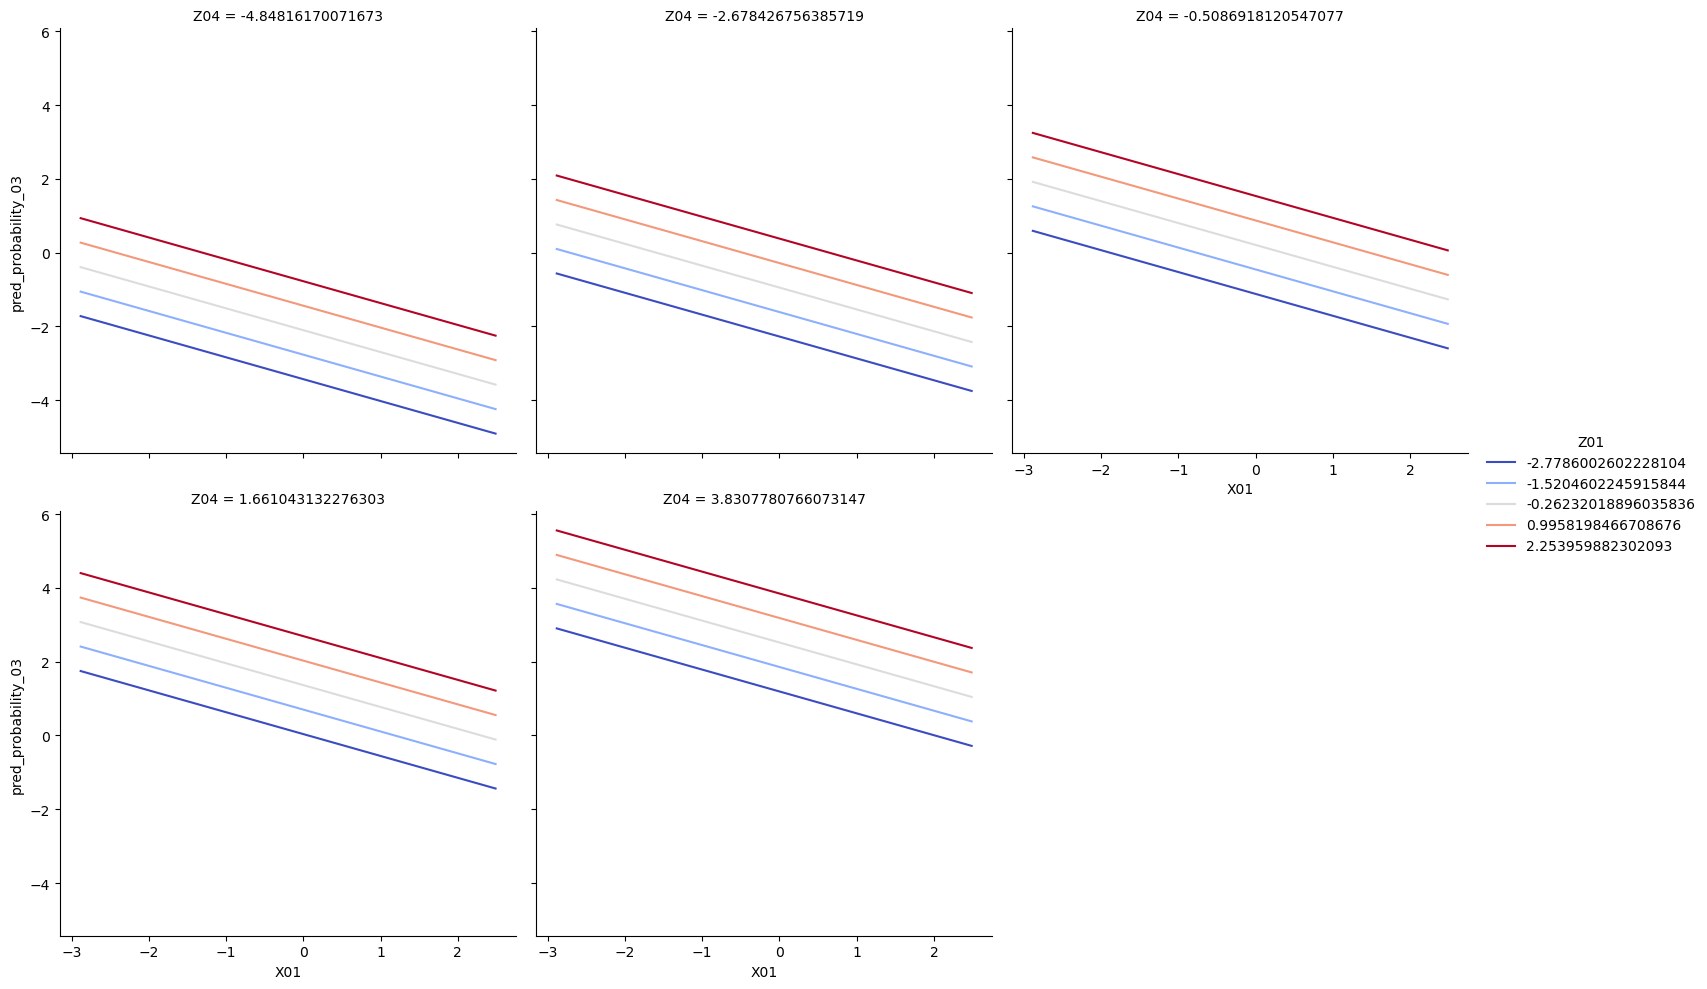

In [176]:
# hue = X17
sns.relplot(
    data=dfviz_03,
    x='X01',
    y='pred_probability_03',
    hue='Z01',
    col='Z04',
    kind='line',
    estimator=None,
    units='Z01',
    col_wrap=3,
    palette="coolwarm"  # Specify the color palette here
)

plt.show()

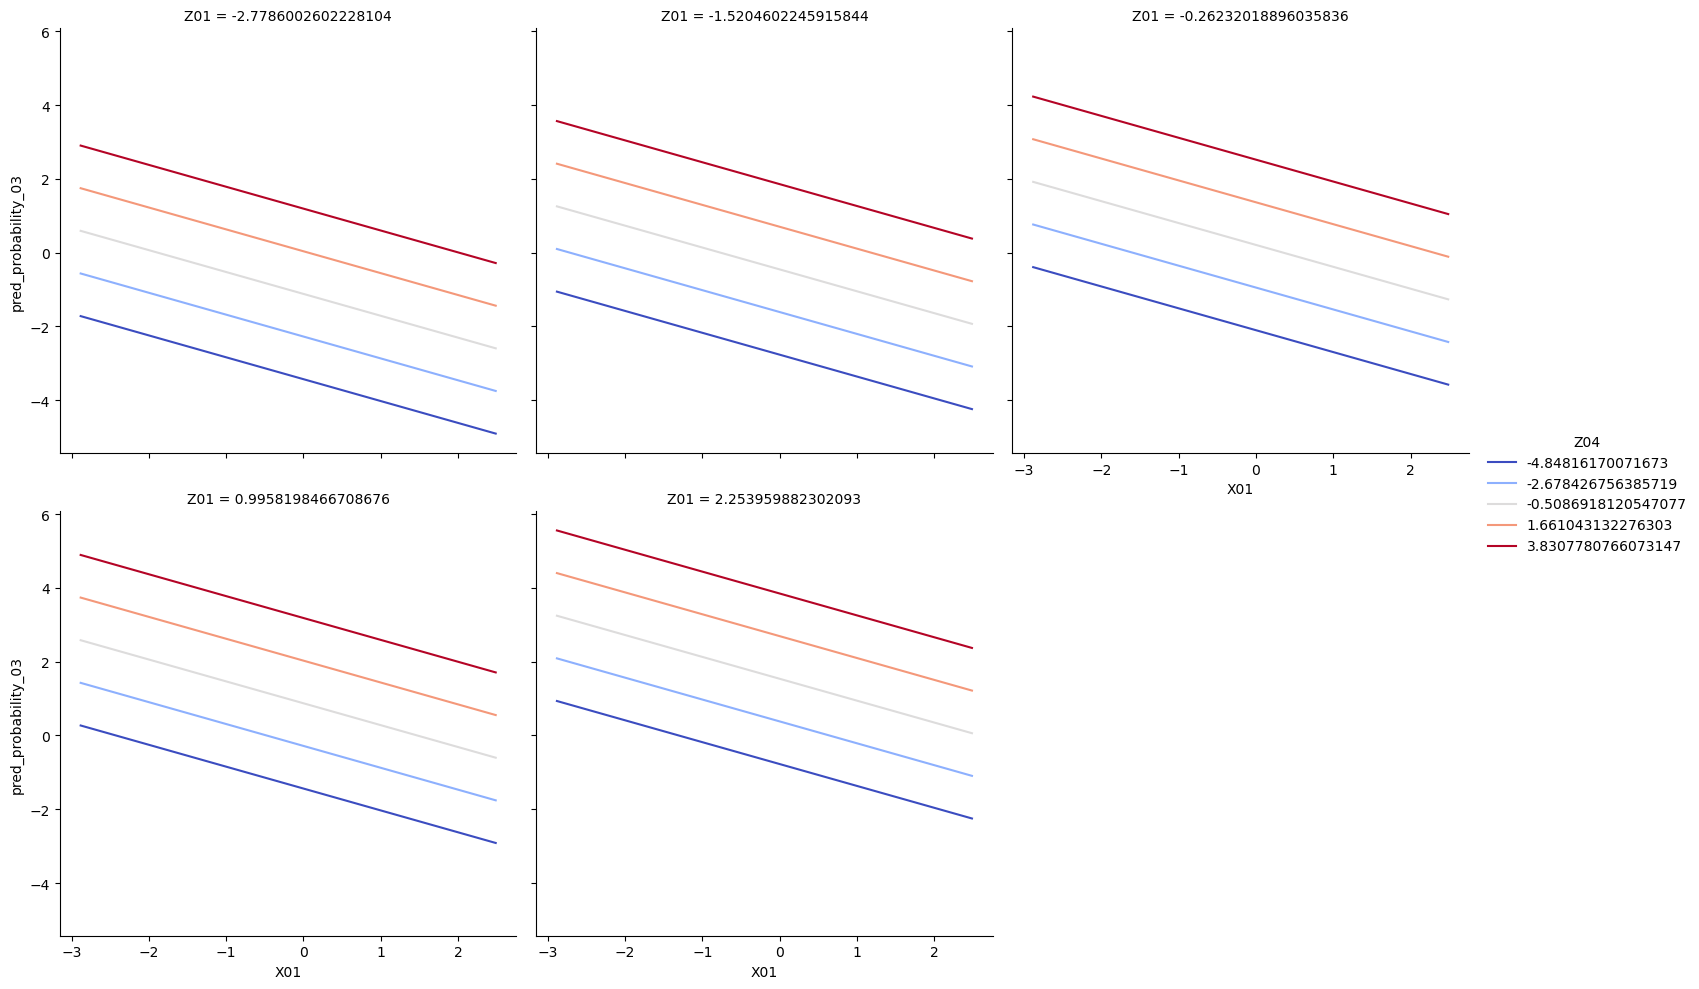

In [177]:
# hue = X02
sns.relplot(
    data=dfviz_03,
    x='X01',
    y='pred_probability_03',
    hue='Z04',
    col='Z01',
    kind='line',
    estimator=None,
    units='Z04',
    col_wrap=3,
    palette="coolwarm"  # Specify the color palette here
)

plt.show()

We observe that model prediction plot increases(shifts upwards) as Z04 increases for various values of Z01. We also observe that model prediction plot increases (moves upwards) as Z01 increases for various values of Z04.

### Model 7

We need to identify 3 most important features for prediction.

In [178]:
# Assuming mod_07.pvalues is a NumPy array
np.abs(mod_07.params).sort_values()

pc05:pc06    0.000743
pc01:pc05    0.000845
pc01:pc02    0.001042
pc06:pc10    0.001150
pc10         0.001319
               ...   
pc04         0.072074
pc11         0.078232
pc01         0.085394
pc09:pc10    0.109349
Intercept    0.618834
Length: 67, dtype: float64

In [209]:
input_grid_07 = pd.DataFrame([ (pc01, pc11, pc04)                
for pc01 in np.linspace(df_pca_transformed_int.pc01.min(),
                        df_pca_transformed_int.pc01.max(), num=101)
for pc11 in np.linspace(df_pca_transformed_int.pc11.min(),
                        df_pca_transformed_int.pc11.max(), num=5)
for pc04 in np.linspace(df_pca_transformed_int.pc04.min(),
                        df_pca_transformed_int.pc04.max(), num=5)],
                          columns=['pc01', 'pc11', 'pc04'])

In [210]:
# Assign constant values for all other inputs
df_new = df_pca_transformed_int.drop(columns=['Y'])
for column in df_new.columns:
    if column not in ['pc01', 'pc11', 'pc04']:
        input_grid_07[column] = df_new[column].mean()

In [211]:
input_grid_07.shape

(2525, 11)

In [212]:
input_grid_07.nunique()

pc01    101
pc11      5
pc04      5
pc02      1
pc03      1
pc05      1
pc06      1
pc07      1
pc08      1
pc09      1
pc10      1
dtype: int64

In [213]:
dfviz_07 = input_grid_07.copy()

In [214]:
dfviz_07['pred_probability_07'] = mod_07.predict( input_grid_07 )

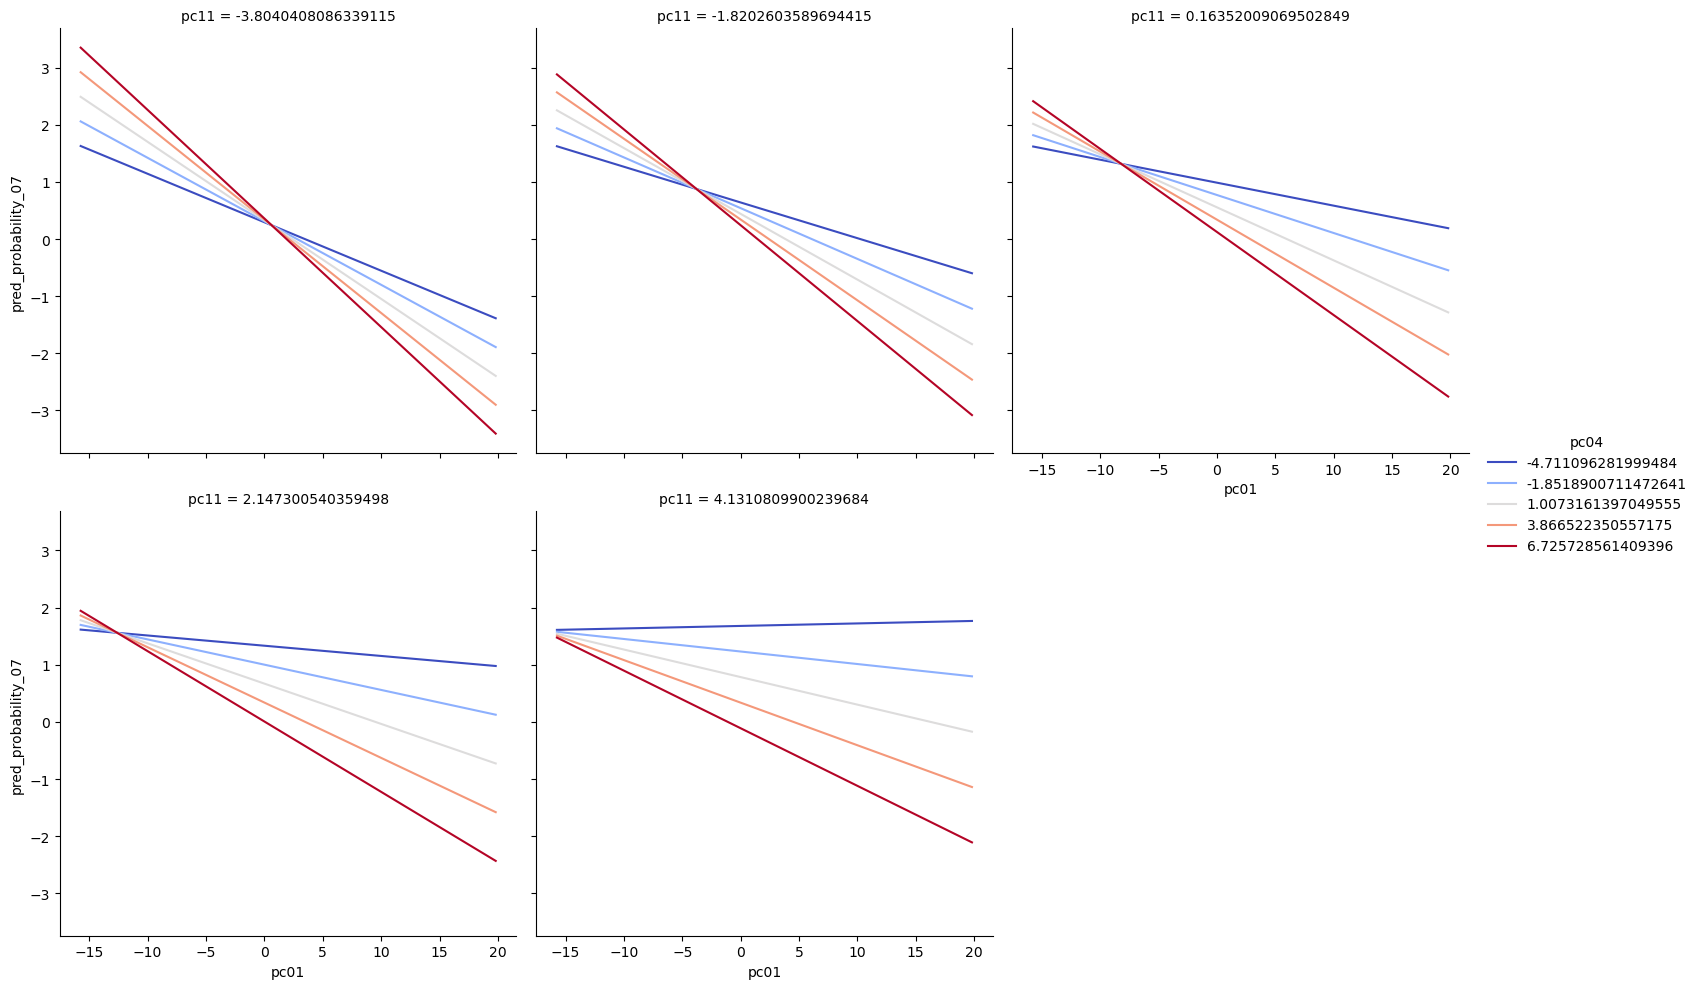

In [215]:
# hue = pc05
sns.relplot(
    data=dfviz_07,
    x='pc01',
    y='pred_probability_07',
    hue='pc04',
    col='pc11',
    kind='line',
    estimator=None,
    units='pc04',
    col_wrap=3,
    palette="coolwarm"  # Specify the color palette here
)

plt.show()

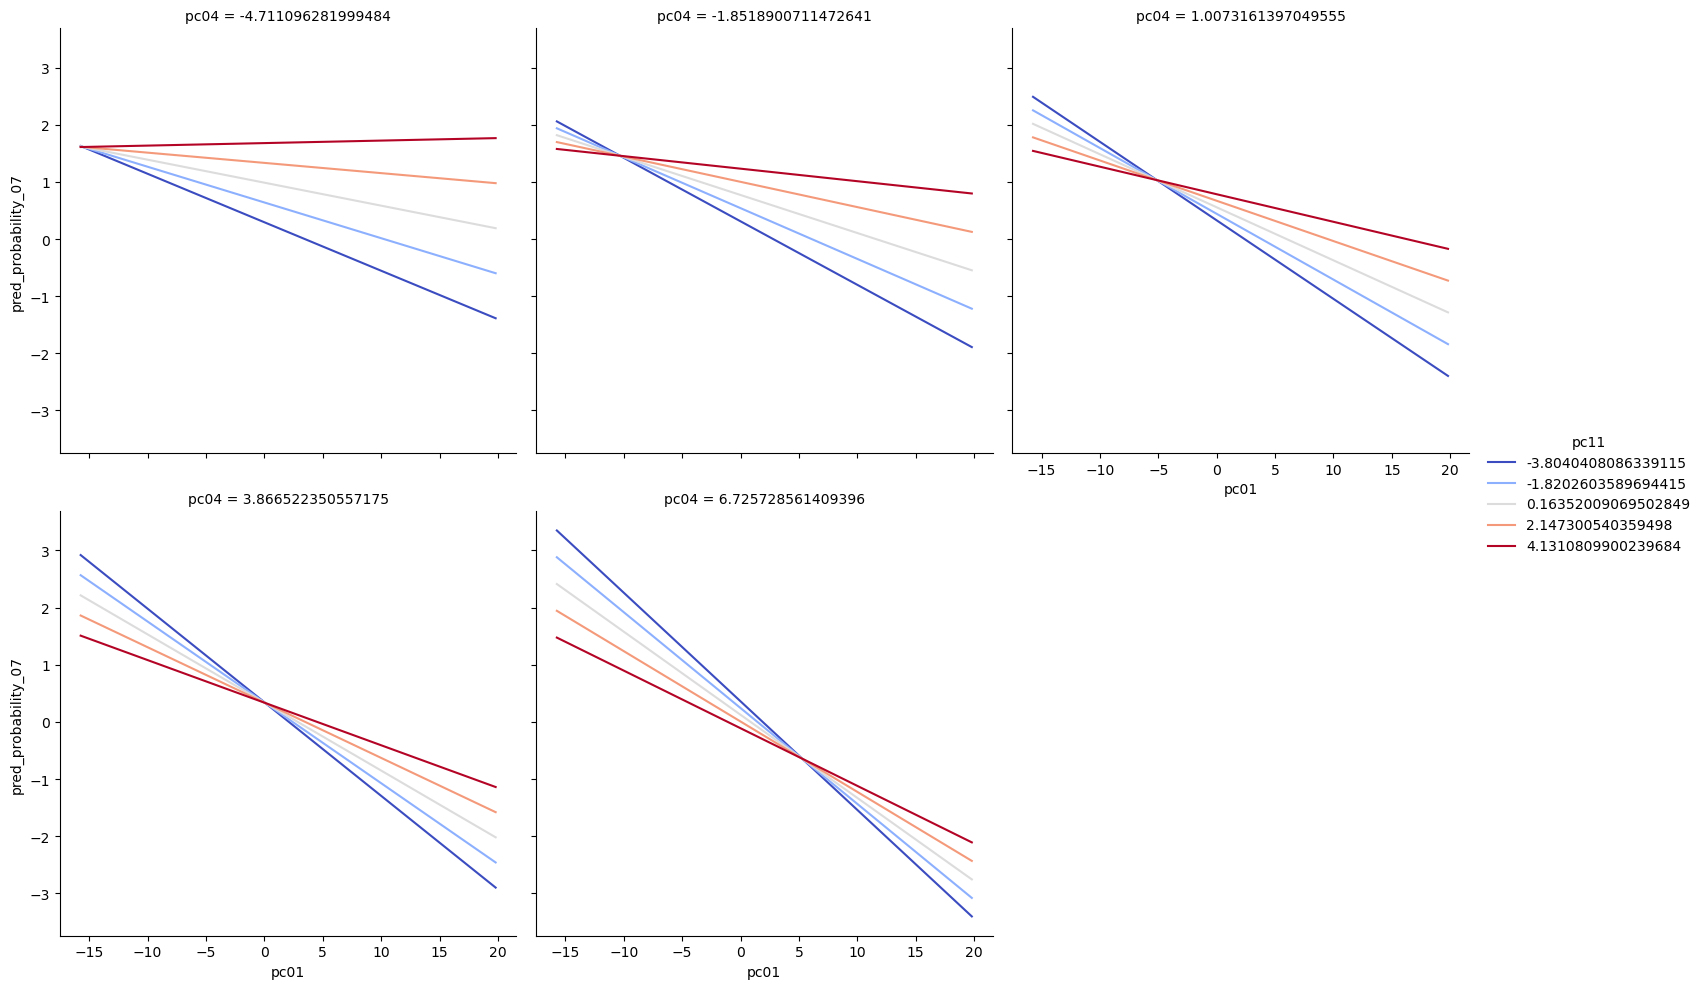

In [216]:
# hue = pc06
sns.relplot(
    data=dfviz_07,
    x='pc01',
    y='pred_probability_07',
    hue='pc11',
    col='pc04',
    kind='line',
    estimator=None,
    units='pc11',
    col_wrap=3,
    palette="coolwarm"  # Specify the color palette here
)

plt.show()

The model prediction plot has negative slope for pc04$>-2$ and the slopes are increasing as pc11 increases. positive slope for pc04$=-4.7$ and pc$11=4.13$. 

We also observe that the plot decreases(shifts downwards) as pc04 values increases( for all values of pc11).



In [225]:
input_grid_071 = pd.DataFrame([ (pc10, pc05, pc06)                
for pc10 in np.linspace(df_pca_transformed_int.pc10.min(),
                        df_pca_transformed_int.pc10.max(), num=101)
for pc05 in np.linspace(df_pca_transformed_int.pc05.min(),
                        df_pca_transformed_int.pc05.max(), num=5)
for pc06 in np.linspace(df_pca_transformed_int.pc06.min(),
                        df_pca_transformed_int.pc06.max(), num=5)],
                          columns=['pc10', 'pc05', 'pc06'])

In [226]:
# Assign constant values for all other inputs
df_new1 = df_pca_transformed_int.drop(columns=['Y'])
for column in df_new.columns:
    if column not in ['pc10', 'pc05', 'pc06']:
        input_grid_071[column] = df_new[column].mean()

In [227]:
input_grid_071.shape

(2525, 11)

In [228]:
input_grid_071.nunique()

pc10    101
pc05      5
pc06      5
pc01      1
pc02      1
pc03      1
pc04      1
pc07      1
pc08      1
pc09      1
pc11      1
dtype: int64

In [236]:
dfviz_071 = input_grid_071.copy()

In [237]:
dfviz_071['pred_probability_071'] = mod_07.predict( input_grid_071 )

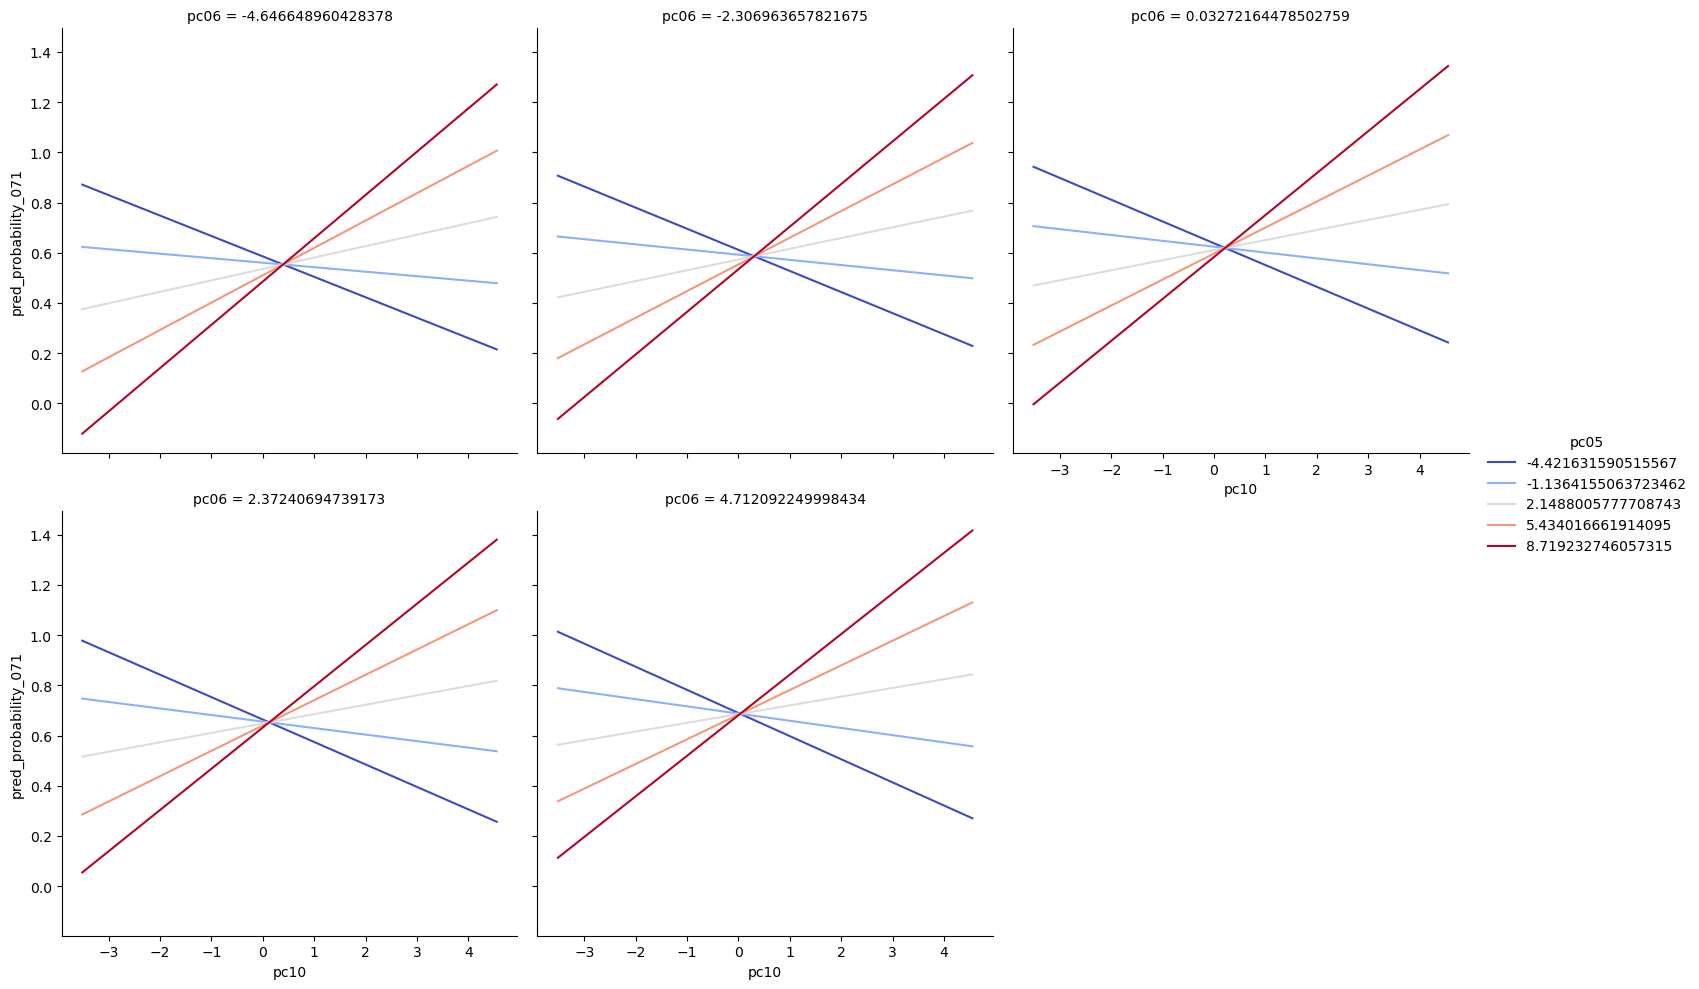

In [239]:
# hue = pc05
sns.relplot(
    data=dfviz_071,
    x='pc10',
    y='pred_probability_071',
    hue='pc05',
    col='pc06',
    kind='line',
    estimator=None,
    units='pc05',
    col_wrap=3,
    palette="coolwarm"  # Specify the color palette here
)

plt.show()

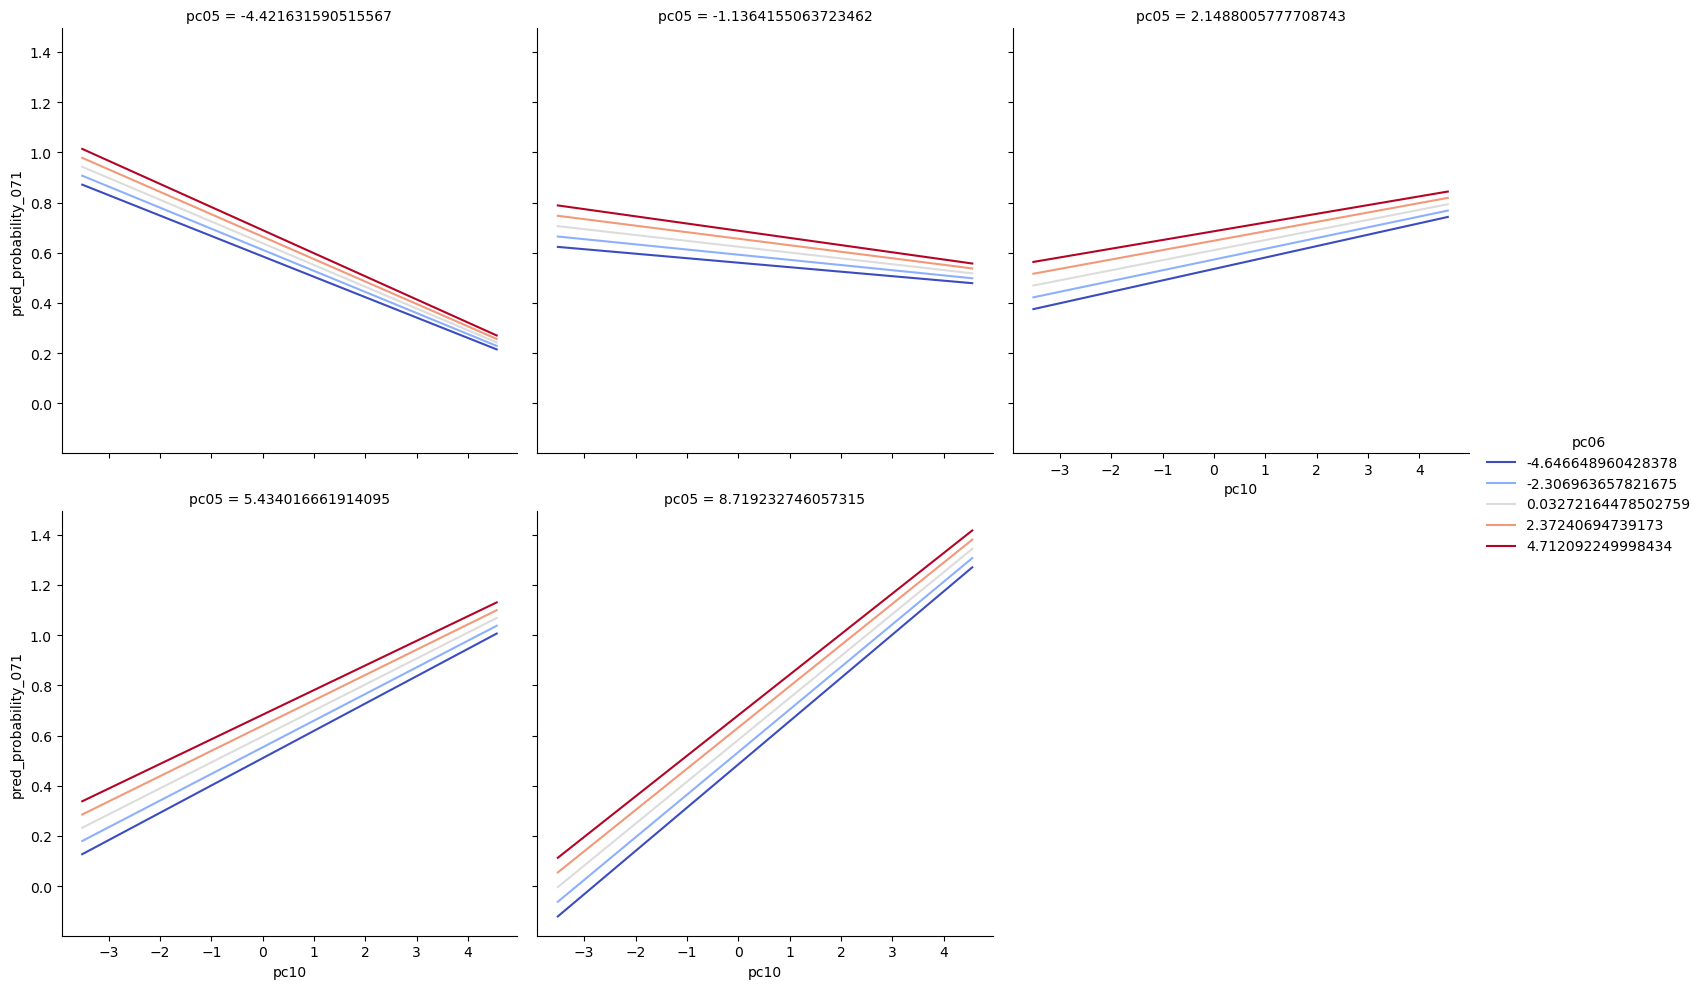

In [240]:
# hue = pc06
sns.relplot(
    data=dfviz_071,
    x='pc10',
    y='pred_probability_071',
    hue='pc06',
    col='pc05',
    kind='line',
    estimator=None,
    units='pc06',
    col_wrap=3,
    palette="coolwarm"  # Specify the color palette here
)

plt.show()

We observe that the model prediction plot has negative sope for negative values of pc05 and positive slope for positive values of pc05. We observe that the slope of the model prediction plot goes from negative to positive(increases) as pc05 values goes from negative to positive(increases). 

We also observe that the plot increases(shifts upwards) as pc06 values increases( for all values of pc05).

